# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Dhruti Shah  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

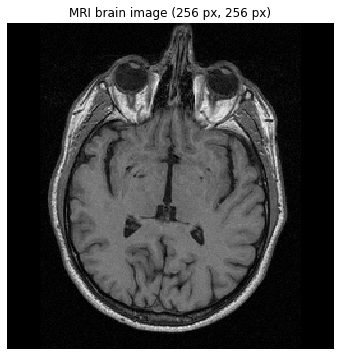

In [44]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing

Using two different homogenity criterion:
1. intensity > threshold
2. intensity difference between neighbors < threshold

We obtain two different results from the above two different criterion, shown below.

In [45]:
import numpy as np

In [237]:
# Intensity > threshold
def check_neighbors(seed_pt1, img, thresh, checked, mask):
    neigh = []
    seed_pt_i = seed_pt1[0]
    seed_pt_j = seed_pt1[1]
    for j in range(max(0,seed_pt_j-1),min(seed_pt_j+2,256)):
        for i in range(max(0,seed_pt_i-1),min(seed_pt_i+2,256)):
            if img[i][j].astype(int) > thresh and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
            #if abs(img[i][j].astype(int)-img[seed_pt_i][seed_pt_j].astype(int)) < thresh and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
                if (i,j) not in checked:
                    neigh += [(i,j)]
                    mask[i][j] = True
    return neigh, mask

def region_growing(mask, seed_pt, img, thresh):
    mask[seed_pt[0]][seed_pt[1]] = True
    to_check = [seed_pt]
    checked = []
    while(len(to_check)>0):
        neighbors = []
        for i in to_check:
            neigh, mask = check_neighbors(i, img, thresh, checked, mask)
            neighbors += neigh
            checked += neigh
        to_check = neighbors
    
    return mask

In [238]:
# Intensity difference between neighbors < threshold
def check_neighbors1(seed_pt1, img, thresh, checked, mask):
    neigh = []
    seed_pt_i = seed_pt1[0]
    seed_pt_j = seed_pt1[1]
    for j in range(max(0,seed_pt_j-1),min(seed_pt_j+2,256)):
        for i in range(max(0,seed_pt_i-1),min(seed_pt_i+2,256)):
            #if img[i][j].astype(int) > 69 and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
            if abs(img[i][j].astype(int)-img[seed_pt_i][seed_pt_j].astype(int)) < thresh and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
                if (i,j) not in checked:
                    neigh += [(i,j)]
                    mask[i][j] = True
    return neigh, mask

def region_growing1(mask, seed_pt, img, thresh):
    mask[seed_pt[0]][seed_pt[1]] = True
    to_check = [seed_pt]
    checked = []
    while(len(to_check)>0):
        neighbors = []
        for i in to_check:
            neigh, mask = check_neighbors1(i, img, thresh, checked, mask)
            neighbors += neigh
            checked += neigh
        to_check = neighbors
    
    return mask

In [239]:
mask = np.zeros([im_h, im_w]).astype(bool)
seed_pt = (im_h//2, im_w//2+20)
mask = region_growing(mask, seed_pt, brain_im, 69)

mask1 = np.zeros([im_h, im_w]).astype(bool)
seed_pt = (im_h//2, im_w//2+20)
mask1 = region_growing1(mask1, seed_pt, brain_im, 8)

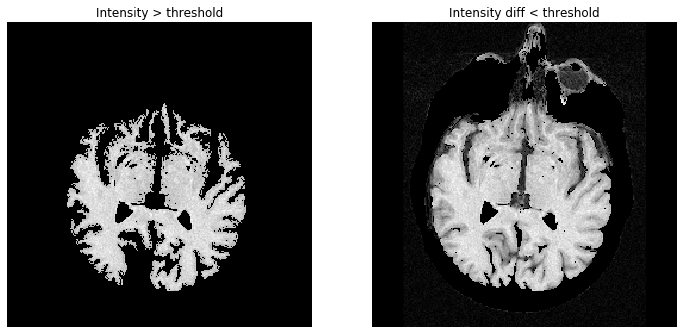

In [240]:
brain_im1 = brain_im.copy()
brain_im1[np.logical_not(mask)]=0

brain_im2 = brain_im.copy()
brain_im2[np.logical_not(mask1)]=0

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(brain_im1, cmap='gray')
ax[0].set_title('Intensity > threshold')
ax[0].axis('off')

ax[1].imshow(brain_im2, cmap='gray')
ax[1].set_title('Intensity diff < threshold')
ax[1].axis('off')

plt.show()

#### Post - processing
For the first image, we see that some parts of the brain are not detected. For the second one, we see that the entire brain in addition to other pixels are detected. We can correctly get only the brain pixels by post-processing the second image.
We have 2 steps. Firstly, we threshold the image, to remove some of the unwanted components. Then we detect the connected components, and discard those whose size is smaller than a certain threshold. In this way, we get an accurate segment of the brain.

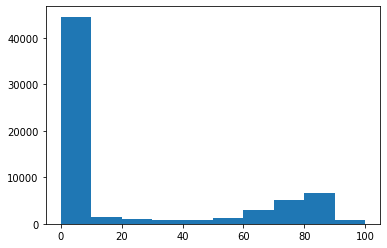

In [241]:
plt.hist(brain_im2.ravel());
plt.show()

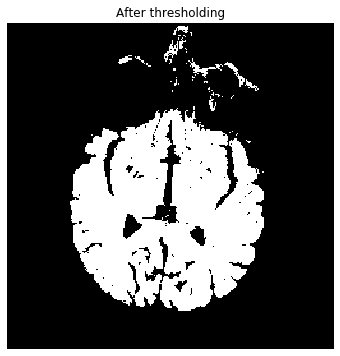

In [242]:
mask1 = brain_im2 > 50

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mask1, cmap='gray')
ax.set_title('After thresholding')
ax.axis('off')

plt.show()

In [243]:
from scipy import ndimage as ndi

In [244]:
label_objects, nb_labels = ndi.label(mask1)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 80
mask_sizes[0] = 0
mask_cleaned = mask_sizes[label_objects]

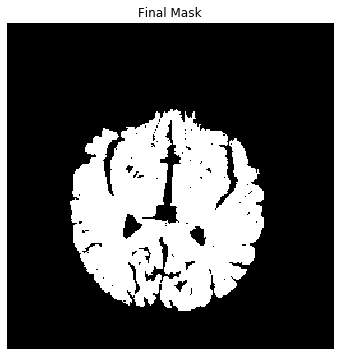

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mask_cleaned, cmap='gray')
ax.set_title('Final Mask')
ax.axis('off')

plt.show()

In [246]:
print('Size of brain (in pixels) is:', np.sum(mask_cleaned))

Size of brain (in pixels) is: 16177


### 1.3 Contour detection
Add your implementation and discussion

In [290]:
import skimage.filters
from skimage import measure
from skimage import morphology
from skimage.feature import canny
import scipy.ndimage as ndimage
from skimage.segmentation import active_contour

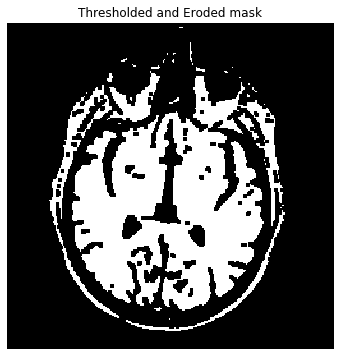

In [647]:
brain_im2 = skimage.filters.gaussian(brain_im,sigma=0.01)
mask = morphology.binary_erosion(brain_im2 > 0.2, selem=np.ones([3,3]))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mask, cmap='gray')
ax.set_title('Thresholded and Eroded mask')
ax.axis('off')

plt.show()

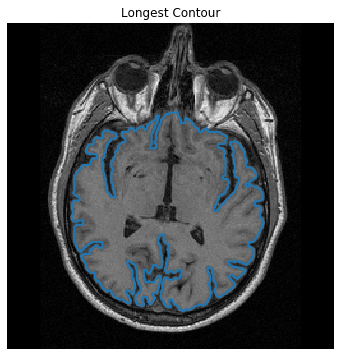

In [648]:
contours = measure.find_contours(mask, 0.24)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im2, cmap='gray')
ax.set_title('Longest Contour')
ax.axis('off')

max_len = 0
longest_c = contours[0]
index_longest = 0

for n, contour in enumerate(contours):
    if len(contour) > max_len:
        max_len = len(contour)
        longest_c = contour
        index_longest = n
    #ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.plot(longest_c[:, 1], longest_c[:, 0], linewidth=2)
plt.show()

In [646]:
mask_longest = ndimage.binary_fill_holes(mask1)
mask_holes = np.zeros(brain_im.shape).astype(bool)

for n, contour in enumerate(contours):
    mask_temp = np.zeros(brain_im.shape).astype(bool)
    if n!=index_longest:
        if(len(contour)>60):
            mask_temp[contour[:,0].astype(int),contour[:,1].astype(int)] = True
            mask_temp = ndimage.binary_fill_holes(mask_temp)
            mask_holes = np.logical_or((mask_temp),mask_holes)

final_mask = np.logical_and(mask_longest, np.logical_not(mask_holes))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(final_mask, cmap='gray')
ax.set_title('Final result')
ax.axis('off')

plt.show()

ValueError: operands could not be broadcast together with shapes (1,480,640) (256,256) 

In [423]:
print('Size of brain (in pixels) is:', np.sum(final_mask))

Size of brain (in pixels) is: 14581


### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [425]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


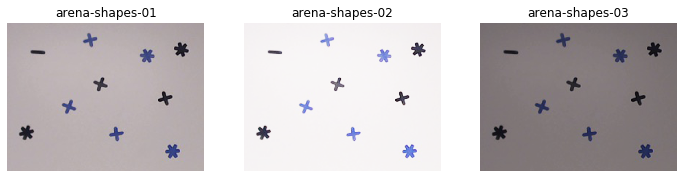

In [426]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

In [592]:
from skimage.color import rgb2hsv, hsv2rgb
import skimage.color
from scipy.spatial import distance

In [493]:
def illumination_invariance(im):
    hsv_im = rgb2hsv(im)
    temp = np.ones(hsv_im[:,:,2].shape)
    hsv_im[:,:,2] = np.minimum(hsv_im[:,:,2]+(1-np.mean(hsv_im[:,:,2])), temp)
    return hsv2rgb(hsv_im)

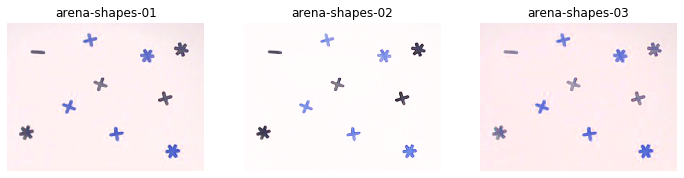

In [607]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    im1 = illumination_invariance(im)
    ax.imshow((im1))
    ax.axis('off')
    ax.set_title(nm)

plt.show()

In [633]:
def count_shapes(image, gray_thresh, dist_thresh):
    img = illumination_invariance(image)
    #plt.hist(skimage.color.rgb2gray(img).ravel(), bins = 50)
    mask = skimage.color.rgb2gray(img)<gray_thresh
    #plt.imshow(mask, cmap='gray')
    
    blobs_labels = measure.label(mask, background=0)
    #plt.imshow(blobs_labels, cmap='nipy_spectral')
    
    labels = np.sort(np.unique(blobs_labels.ravel()))[1:]
    seen_colors = []
    count_shapes = []
    for i in labels:
        mask1 = [blobs_labels==i]
        rgb_mean = np.mean(img[tuple(mask1)], axis=0)
        seen_colors.append(rgb_mean)
        
    count1 = np.sum(distance.cdist(seen_colors, seen_colors)[0,:] > dist_thresh)
    count2 = len(labels) - count1
    return count1, count2

In [634]:
for ind, i in enumerate(images):
    print('For image',ind,'number of shapes of each color: ',count_shapes(i,0.7,0.2))

For image 0 number of shapes of each color:  (5, 5)
For image 1 number of shapes of each color:  (5, 5)
For image 2 number of shapes of each color:  (5, 5)


### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

In [635]:
def count_area(image, gray_thresh, dist_thresh):
    img = illumination_invariance(image)
    #plt.hist(skimage.color.rgb2gray(img).ravel(), bins = 50)
    mask = skimage.color.rgb2gray(img)<gray_thresh
    #plt.imshow(mask, cmap='gray')
    
    blobs_labels = measure.label(mask, background=0)
    #plt.imshow(blobs_labels, cmap='nipy_spectral')
    
    labels = np.sort(np.unique(blobs_labels.ravel()))[1:]
    seen_colors = []
    count_shapes = []
    for i in labels:
        mask1 = [blobs_labels==i]
        rgb_mean = np.mean(img[tuple(mask1)], axis=0)
        seen_colors.append(rgb_mean)
        
    colors = (distance.cdist(seen_colors, seen_colors)[0,:] > dist_thresh)
    color1_labels = np.nonzero(colors)[0]+1
    color2_labels = np.nonzero(np.logical_not(colors))[0]+1
    
    num_pixels1 = 0
    num_pixels2 = 0
    
    for i in color1_labels:
        num_pixels1 += np.sum(blobs_labels==i)
    for i in color2_labels:
        num_pixels2 += np.sum(blobs_labels==i)
        
    return num_pixels1, num_pixels2

In [636]:
for ind, i in enumerate(images):
    print('For image',ind,'number of pixels of each color: ',count_area(i,0.7,0.2))

For image 0 number of pixels of each color:  (4834, 5029)
For image 1 number of pixels of each color:  (4415, 4126)
For image 2 number of pixels of each color:  (4425, 4933)
